In [1]:
import scanpy as sc 
import pandas as pd 
import numpy as np 
from tqdm import tqdm  

In [2]:
import matplotlib.pyplot as plt
import cell2location
from cell2location.models import Cell2location, RegressionModel
from cell2location.plt import plot_spatial
from cell2location.utils import select_slide
from cell2location.utils.filtering import filter_genes

/dartfs-hpc/rc/home/k/f006fpk/anaconda3/envs/cell2loc_env/lib/python3.9/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/dartfs-hpc/rc/home/k/f006fpk/anaconda3/envs/cell2loc_env/lib/python3.9/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (


In [3]:
import scvi 
import os

In [4]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1,3"

In [5]:
sc_adata = sc.read_h5ad("./labeled_data/SP18_16438_A3_cell_labels.h5ad")

/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Gokul_Srinivasan/anaconda3/envs/cell2loc_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [14]:
visium_adata = sc.read_visium('/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/projects/visium_colon_9_27_23/visium_data/st_data/83-3/outs/')

/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Gokul_Srinivasan/anaconda3/envs/cell2loc_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Gokul_Srinivasan/anaconda3/envs/cell2loc_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [15]:
# visium_adata = sc.read_h5ad("/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Gokul_Srinivasan/Colon_ST_Training/gene_selection/all_genes_filtered/data/adatas/97_A7-81_A11_0_adata.h5ad")

In [16]:
visium_adata.var_names_make_unique()
sc_adata.var_names_make_unique()

In [17]:
top_1000 = pd.read_csv("/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Gokul_Srinivasan/Colon_ST_Training/new_top_1000.csv", index_col = 0)
visium_adata = visium_adata[:, top_1000["gene"]]

In [18]:
# find shared genes and subset both anndata and reference signatures
intersect = np.intersect1d(visium_adata.var_names, sc_adata.var_names)

visium_adata = visium_adata[:, intersect].copy()
sc_adata = sc_adata[:, intersect].copy()

In [19]:
sc_adata

AnnData object with n_obs × n_vars = 11591 × 998
    obs: 'cell_type'
    var: 'gene_ids', 'feature_types', 'genome'

In [20]:
# prepare anndata for the regression model
RegressionModel.setup_anndata(
    adata=sc_adata,
    # # 10X reaction / sample / batch
    # batch_key="Sample",
    
    # cell type, covariate used for constructing signatures
    labels_key="cell_type",
)
mod = RegressionModel(sc_adata)
mod.view_anndata_setup()

# Use all data for training (validation not implemented yet, train_size=1)
mod.train(
    max_epochs=250,
    batch_size=2500,
    train_size=1,
    lr=0.002,
)

/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Gokul_Srinivasan/anaconda3/envs/cell2loc_env/lib/python3.9/abc.py:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


Anndata setup with scvi-tools version 1.0.4.

Setup via `RegressionModel.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': None,
│   'labels_key': 'cell_type',
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │   1   │
│         n_cells          │ 11591 │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │   7   │
│          n_vars          │  998  │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    ind_x     │   adata.obs['_indices']   │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                     batch State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_batch'] │     0      │          0          │
└──────────────────────────┴────────────┴─────────────────────┘

                    labels State Registry                    
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location     ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['cell_type'] │     B      │          0          │
│                        │    Epi     │          1          │
│                        │    Mast    │          2          │
│                        │  Myeloid   │          3          │
│                        │   Plasma   │          4          │
│                        │   Strom    │          5          │
│                        │   TNKILC   │          6          │
└────────────────────────┴────────────┴─────────────────────┘

/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Gokul_Srinivasan/anaconda3/envs/cell2loc_env/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:168: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/u ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Gokul_Srinivasan/anaconda3/envs/cell2loc_env/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:168: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/u ...
/dartfs/rc/n

Epoch 250/250: 100%|██████████████████████████████████████████████████| 250/250 [00:58<00:00,  4.66it/s, v_num=1, elbo_train=4.88e+6]

`Trainer.fit` stopped: `max_epochs=250` reached.


Epoch 250/250: 100%|██████████████████████████████████████████████████| 250/250 [00:58<00:00,  4.29it/s, v_num=1, elbo_train=4.88e+6]


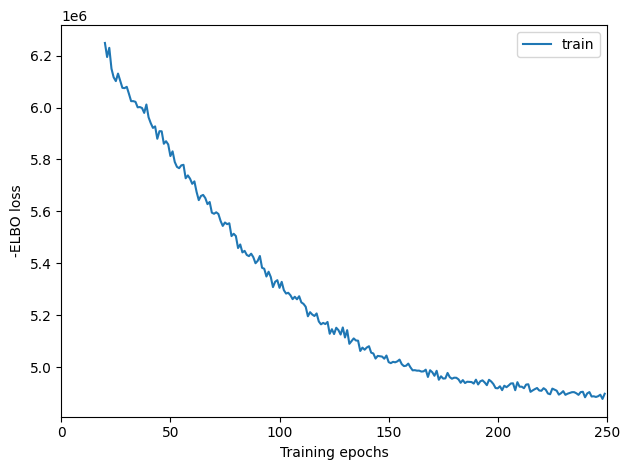

In [21]:
mod.plot_history(20)

In [22]:
sc_adata = mod.export_posterior(
    sc_adata,
    sample_kwargs={"num_samples": 1000, "batch_size": 2500, "use_gpu": True},
)

/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Gokul_Srinivasan/anaconda3/envs/cell2loc_env/lib/python3.9/site-packages/scvi/model/base/_pyromixin.py:388: UserWarning: `use_gpu` is deprecated in v1.0 and will be removed in v1.1. Please use `accelerator` and `devices` instead.
  _, _, device = parse_device_args(


Sampling global variables, sample: 100%|██████████████████████████████████████████████████████████| 999/999 [00:06<00:00, 165.55it/s]


In [23]:
# export estimated expression in each cluster
if "means_per_cluster_mu_fg" in sc_adata.varm.keys():
    inf_aver = sc_adata.varm["means_per_cluster_mu_fg"][
        [f"means_per_cluster_mu_fg_{i}" for i in sc_adata.uns["mod"]["factor_names"]]
    ].copy()
else:
    inf_aver = sc_adata.var[
        [f"means_per_cluster_mu_fg_{i}" for i in sc_adata.uns["mod"]["factor_names"]]
    ].copy()
inf_aver.columns = sc_adata.uns["mod"]["factor_names"]
inf_aver.iloc[0:5, 0:5]

B       Epi      Mast   Myeloid    Plasma
A1CF    0.002722  0.187293  0.008330  0.002952  0.001776
A2M     0.043051  0.095213  0.097772  0.697619  0.047853
AACS    0.033560  0.410493  0.245168  0.071488  0.136774
ABCC3   0.058402  1.300192  0.152820  0.236351  0.018774
ABHD11  0.067812  0.897884  0.220615  0.104671  0.087505

In [24]:
inf_aver

B       Epi      Mast   Myeloid    Plasma     Strom    TNKILC
A1CF    0.002722  0.187293  0.008330  0.002952  0.001776  0.008737  0.001145
A2M     0.043051  0.095213  0.097772  0.697619  0.047853  2.380926  0.029193
AACS    0.033560  0.410493  0.245168  0.071488  0.136774  0.162526  0.056604
ABCC3   0.058402  1.300192  0.152820  0.236351  0.018774  0.142798  0.019287
ABHD11  0.067812  0.897884  0.220615  0.104671  0.087505  0.194264  0.053660
...          ...       ...       ...       ...       ...       ...       ...
ZG16B   0.003711  0.071331  0.001348  0.004999  0.001555  0.007276  0.001156
ZNF511  0.034315  0.242822  0.054710  0.071222  0.057303  0.095583  0.026925
ZNF664  0.043218  0.177432  0.107384  0.028339  0.055586  0.062920  0.017380
ZNF703  0.126924  1.615036  0.325603  0.165764  0.104172  0.755591  0.058202
ZWINT   0.011195  0.205294  0.063520  0.029603  0.019835  0.055060  0.028492

[998 rows x 7 columns]

In [25]:
# find shared genes and subset both anndata and reference signatures
intersect = np.intersect1d(visium_adata.var_names, inf_aver.index)
visium_adata = visium_adata[:, intersect].copy()
inf_aver = inf_aver.loc[intersect, :].copy()

In [26]:
visium_adata.X.todense()

matrix([[ 1.,  3.,  0., ...,  0.,  2.,  1.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  2., ...,  2., 20.,  3.],
        ...,
        [ 1.,  6.,  2., ...,  2., 13.,  2.],
        [ 0.,  2.,  3., ...,  2., 12.,  0.],
        [ 0.,  7.,  1., ...,  3.,  8.,  1.]], dtype=float32)

Anndata setup with scvi-tools version 1.0.4.

Setup via `Cell2location.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': None,
│   'labels_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │   1   │
│         n_cells          │ 14336 │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │   1   │
│          n_vars          │  998  │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    ind_x     │   adata.obs['_indices']   │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                     batch State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_batch'] │     0      │          0          │
└──────────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Gokul_Srinivasan/anaconda3/envs/cell2loc_env/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:168: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/u ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Gokul_Srinivasan/anaconda3/envs/cell2loc_env/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:168: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/u ...
/dartfs/rc/n

Epoch 21534/30000:  72%|██████████████████████████████▏           | 21533/30000 [44:26<27:44,  5.09it/s, v_num=1, elbo_train=2.01e+7]

/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Gokul_Srinivasan/anaconda3/envs/cell2loc_env/lib/python3.9/site-packages/lightning/pytorch/trainer/call.py:53: Detected KeyboardInterrupt, attempting graceful shutdown...


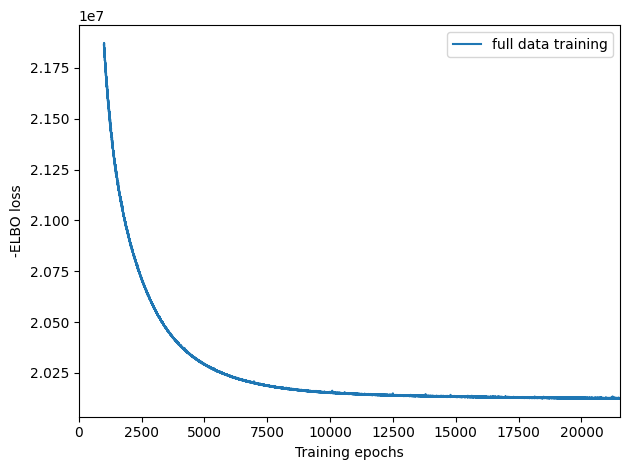

In [27]:
Cell2location.setup_anndata(adata=visium_adata)

mod = Cell2location(
    visium_adata,
    cell_state_df=inf_aver,
    # the expected average cell abundance: tissue-dependent
    # hyper-prior which can be estimated from paired histology:
    N_cells_per_location=30,
    # hyperparameter controlling normalisation of
    # within-experiment variation in RNA detection (using default here):
    detection_alpha=200,
)
mod.view_anndata_setup()

mod.train(
    max_epochs=30000,
    # train using full data (batch_size=None)
    batch_size=None,
    # use all data points in training because
    # we need to estimate cell abundance at all locations
    train_size=1,
)

# plot ELBO loss history during training, removing first 100 epochs from the plot
mod.plot_history(1000)
plt.legend(labels=["full data training"]);

In [44]:
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
visium_adata = mod.export_posterior(
    visium_adata,
    sample_kwargs={"num_samples": 1000, "batch_size": mod.adata.n_obs, "use_gpu": True},
)

/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Gokul_Srinivasan/anaconda3/envs/cell2loc_env/lib/python3.9/site-packages/scvi/model/base/_pyromixin.py:388: UserWarning: `use_gpu` is deprecated in v1.0 and will be removed in v1.1. Please use `accelerator` and `devices` instead.
  _, _, device = parse_device_args(


Sampling global variables, sample: 100%|███████████████████████████████████████████████████████████| 999/999 [00:15<00:00, 63.64it/s]


In [45]:
visium_adata.obsm["q05_cell_abundance_w_sf"]

q05cell_abundance_w_sf_B  q05cell_abundance_w_sf_Epi  \
AACAATCCGAGTGGAC-1                  0.029415                    1.708064   
AACAATGGAACCACAT-1                  0.003735                    1.211428   
AACAATGTGCTCCGAG-1                  0.082068                   27.937248   
AACAATTATCTGCGCC-1                  0.119543                   39.772842   
AACACCAGCCTACTCG-1                  0.244350                   64.656459   
...                                      ...                         ...   
TGTTGGTGATTAGGTA-1                  0.065322                   33.377819   
TGTTGGTGCGCACGAG-1                  0.345787                   10.334304   
TGTTGGTGCGCTTCGC-1                  0.255677                   52.866858   
TGTTGGTGCGGAATCA-1                  0.046095                   17.352979   
TGTTGGTGGACTCAGG-1                  0.031706                   12.238010   

                    q05cell_abundance_w_sf_Mast  \
AACAATCCGAGTGGAC-1                     0.016566   
AACAATGGAACCACAT-1                     0.012646   
AACAATGTGCTCCGAG-1                     0.307859   
AACAATTATCTGCGCC-1                     0.234810   
AACACCAGCCTACTCG-1                     0.518831   
...                                         ...   
TGTTGGTGATTAGGTA-1                     0.225722   
TGTTGGTGCGCACGAG-1                     0.105951   
TGTTGGTGCGCTTCGC-1                     0.493037   
TGTTGGTGCGGAATCA-1                     0.101787   
TGTTGGTGGACTCAGG-1                     0.132921   

                    q05cell_abundance_w_sf_Myeloid  \
AACAATCCGAGTGGAC-1                        1.602935   
AACAATGGAACCACAT-1                        0.017927   
AACAATGTGCTCCGAG-1                        0.076649   
AACAATTATCTGCGCC-1                        0.150685   
AACACCAGCCTACTCG-1                        0.249683   
...                                            ...   
TGTTGGTGATTAGGTA-1                        0.004974   
TGTTGGTGCGCACGAG-1                       14.549089   
TGTTGGTGCGCTTCGC-1                        0.371522   
TGTTGGTGCGGAATCA-1                        0.014385   
TGTTGGTGGACTCAGG-1                        0.447339   

                    q05cell_abundance_w_sf_Plasma  \
AACAATCCGAGTGGAC-1                       0.175475   
AACAATGGAACCACAT-1                       0.000240   
AACAATGTGCTCCGAG-1                       0.044328   
AACAATTATCTGCGCC-1                       0.159651   
AACACCAGCCTACTCG-1                       0.047875   
...                                           ...   
TGTTGGTGATTAGGTA-1                       0.001294   
TGTTGGTGCGCACGAG-1                       0.814970   
TGTTGGTGCGCTTCGC-1                       0.110367   
TGTTGGTGCGGAATCA-1                       0.000550   
TGTTGGTGGACTCAGG-1                       0.003300   

                    q05cell_abundance_w_sf_Strom  \
AACAATCCGAGTGGAC-1                      4.897900   
AACAATGGAACCACAT-1                      0.101785   
AACAATGTGCTCCGAG-1                      0.001390   
AACAATTATCTGCGCC-1                      2.260955   
AACACCAGCCTACTCG-1                      1.117715   
...                                          ...   
TGTTGGTGATTAGGTA-1                      0.000283   
TGTTGGTGCGCACGAG-1                      7.214292   
TGTTGGTGCGCTTCGC-1                      1.421548   
TGTTGGTGCGGAATCA-1                      0.008984   
TGTTGGTGGACTCAGG-1                      0.311725   

                    q05cell_abundance_w_sf_TNKILC  
AACAATCCGAGTGGAC-1                       0.112741  
AACAATGGAACCACAT-1                       0.006828  
AACAATGTGCTCCGAG-1                       0.078157  
AACAATTATCTGCGCC-1                       0.115683  
AACACCAGCCTACTCG-1                       0.223748  
...                                           ...  
TGTTGGTGATTAGGTA-1                       0.061583  
TGTTGGTGCGCACGAG-1                       1.279391  
TGTTGGTGCGCTTCGC-1                       0.192806  
TGTTGGTGCGGAATCA-1                       0.097187  
TGTTGGTGGAC

In [46]:
visium_adata.obsm["spatial"] = visium_adata.obsm["spatial"].astype(float)

In [55]:
visium_adata.obs[visium_adata.uns["mod"]["factor_names"]] = visium_adata.obsm[
    "q05_cell_abundance_w_sf"
]

In [56]:
colors = [
        "B",
        "Epi",
        "Mast",
        "Myeloid",
        "Plasma",
        "Strom",
        "TNKILC",
    ]

In [57]:
visium_adata.obs.columns

Index(['in_tissue', 'array_row', 'array_col', '_indices', '_scvi_batch',
       '_scvi_labels', 'B', 'Epi', 'Mast', 'Myeloid', 'Plasma', 'Strom',
       'TNKILC'],
      dtype='object')

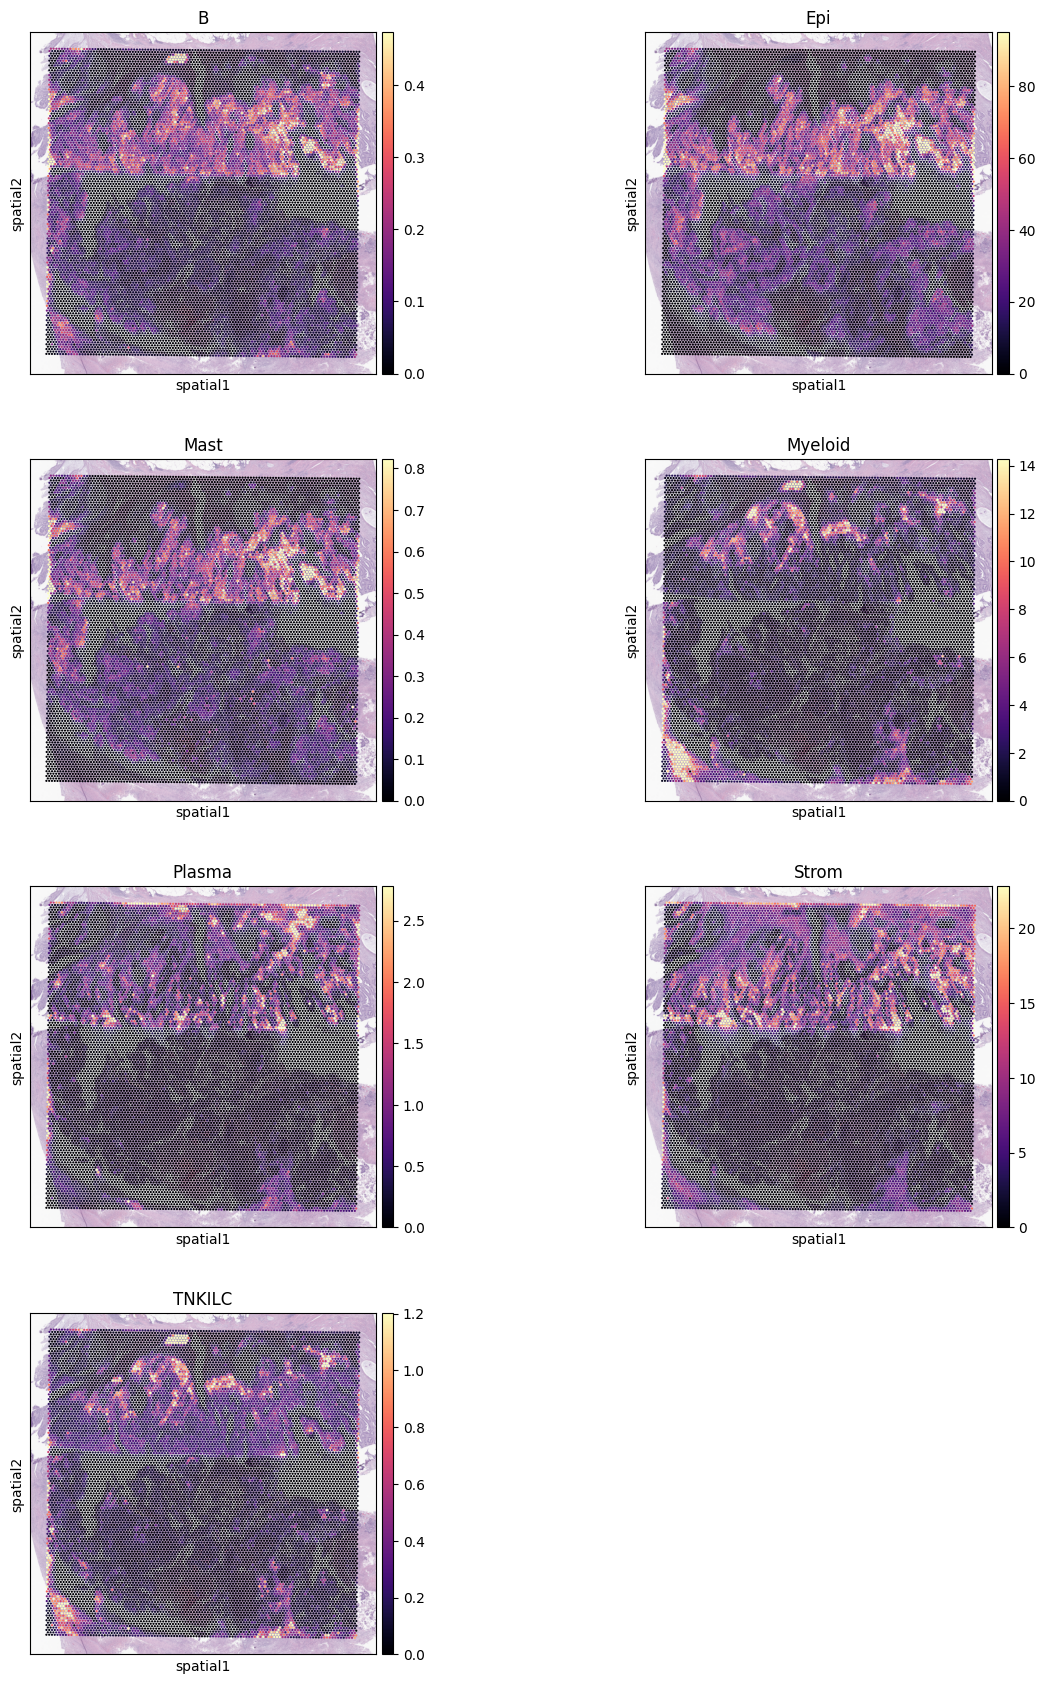

In [58]:
sc.pl.spatial(
        visium_adata,
        cmap="magma",
        # show first 8 cell types
        color=colors,
        ncols=2,
        size=1.3,
        img_key="hires",
        # limit color scale at 99.2% quantile of cell abundance
        vmin=0,
        vmax="p99.2")

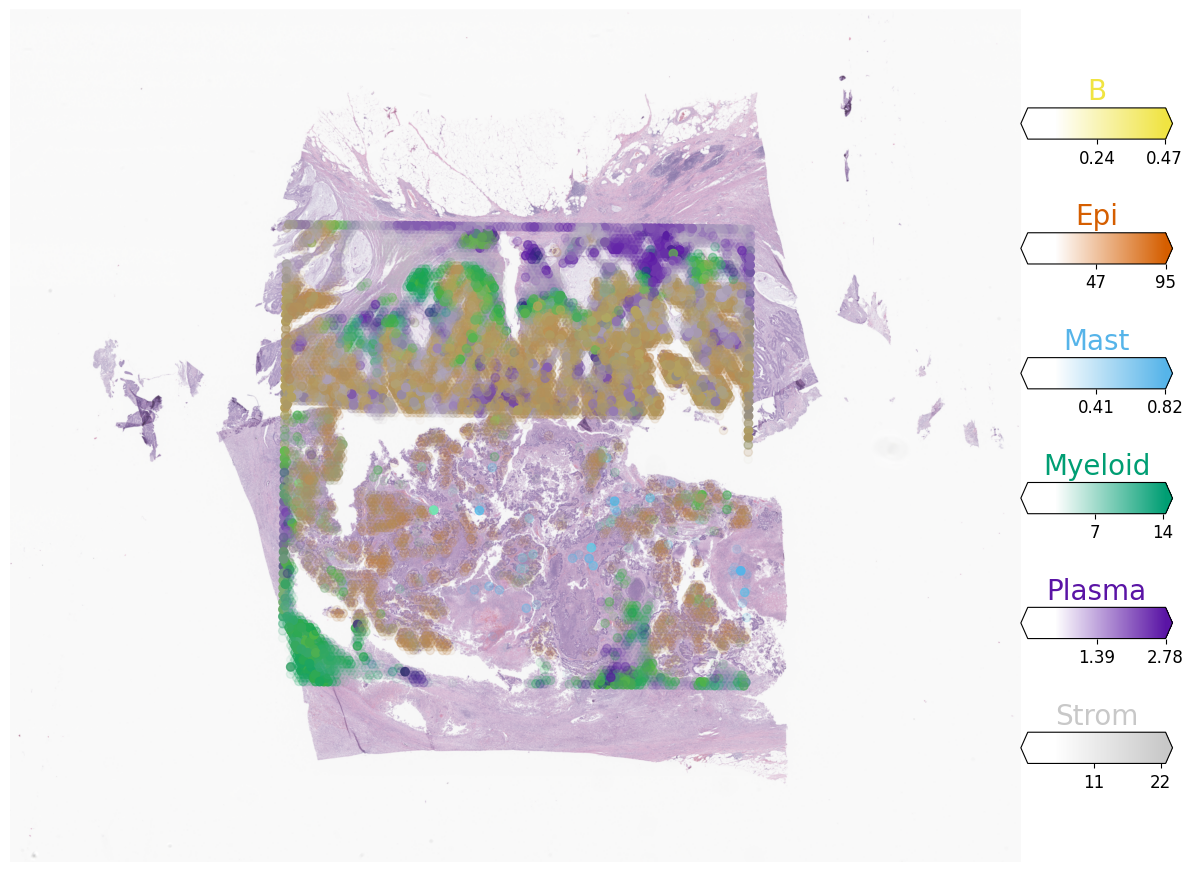

In [59]:
import matplotlib as mpl 
# select up to 6 clusters
clust_labels = ["B",
        "Epi",
        "Mast",
        "Myeloid",
        "Plasma",
        "Strom",
        ]
clust_col = [
    "" + str(i) for i in clust_labels
]  # in case column names differ from labels

# slide = select_slide(visium_adata, "V1_Human_Lymph_Node")

with mpl.rc_context({"figure.figsize": (15, 15)}):
    fig = plot_spatial(
        adata=visium_adata,
        # labels to show on a plot
        color=clust_col,
        labels=clust_labels,
        show_img=True,
        # 'fast' (white background) or 'dark_background'
        style="fast",
        # limit color scale at 99.2% quantile of cell abundance
        max_color_quantile=0.992,
        # size of locations (adjust depending on figure size)
        circle_diameter=6,
        colorbar_position="right",
    )